In [1]:
# importing all the required libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

print("="*50)
print("Cat vs Dog CNN Classifier")
print("="*50)

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
  print(f"Gpu enabled {gpu_devices[0].name}")
else:
  print("No Gpu enabled")

Cat vs Dog CNN Classifier
Gpu enabled /physical_device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ls /content/drive/MyDrive

 CC3_198/   Classroom/  'Colab Notebooks'/   train.zip


In [4]:
!mkdir -p /content/raw_train
!unzip -q /content/drive/MyDrive/train.zip -d /content/raw_train

In [5]:
ls /content/raw_train

train/


In [6]:
!ls /content/raw_train/train

cat.0.jpg      cat.3250.jpg  cat.7751.jpg   dog.12250.jpg  dog.5500.jpg
cat.10000.jpg  cat.3251.jpg  cat.7752.jpg   dog.12251.jpg  dog.5501.jpg
cat.10001.jpg  cat.3252.jpg  cat.7753.jpg   dog.12252.jpg  dog.5502.jpg
cat.10002.jpg  cat.3253.jpg  cat.7754.jpg   dog.12253.jpg  dog.5503.jpg
cat.10003.jpg  cat.3254.jpg  cat.7755.jpg   dog.12254.jpg  dog.5504.jpg
cat.10004.jpg  cat.3255.jpg  cat.7756.jpg   dog.12255.jpg  dog.5505.jpg
cat.10005.jpg  cat.3256.jpg  cat.7757.jpg   dog.12256.jpg  dog.5506.jpg
cat.10006.jpg  cat.3257.jpg  cat.7758.jpg   dog.12257.jpg  dog.5507.jpg
cat.10007.jpg  cat.3258.jpg  cat.7759.jpg   dog.12258.jpg  dog.5508.jpg
cat.10008.jpg  cat.3259.jpg  cat.775.jpg    dog.12259.jpg  dog.5509.jpg
cat.10009.jpg  cat.325.jpg   cat.7760.jpg   dog.1225.jpg   dog.550.jpg
cat.1000.jpg   cat.3260.jpg  cat.7761.jpg   dog.12260.jpg  dog.5510.jpg
cat.10010.jpg  cat.3261.jpg  cat.7762.jpg   dog.12261.jpg  dog.5511.jpg
cat.10011.jpg  cat.3262.jpg  cat.7763.jpg   dog.12262.jpg  dog.55

In [7]:
!find /content/raw_train/train -type f | wc -l

25000


In [8]:
import shutil
import random

source_dir = '/content/raw_train/train'
base_dir = '/content/data'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

for split in [train_dir, val_dir]:
    os.makedirs(os.path.join(split, 'cats'), exist_ok = True)
    os.makedirs(os.path.join(split, 'dogs'), exist_ok = True)

In [9]:
images = os.listdir(source_dir)

random.shuffle(images)

split_index= int(0.8*len(images))

train_images = images[:split_index]
val_images = images[split_index:]

In [10]:
def move_images(image_list, target_dir):
    for img in image_list:

        if img.startswith('cat'):
            label = "cats"
        elif img.startswith('dog'):
            label = 'dogs'
        else:
            continue

        shutil.copy(
            os.path.join(source_dir, img),
            os.path.join(target_dir, label, img)
        )

move_images(train_images, train_dir)
move_images(val_images, val_dir)

In [11]:
# This cell confirms that images were copied correctly
# Zero counts here mean training will fail

print("Train cats:", len(os.listdir("/content/data/train/cats")))
print("Train dogs:", len(os.listdir("/content/data/train/dogs")))
print("Val cats:", len(os.listdir("/content/data/val/cats")))
print("Val dogs:", len(os.listdir("/content/data/val/dogs")))


Train cats: 10000
Train dogs: 10000
Val cats: 2500
Val dogs: 2500


Visualize Sample Images


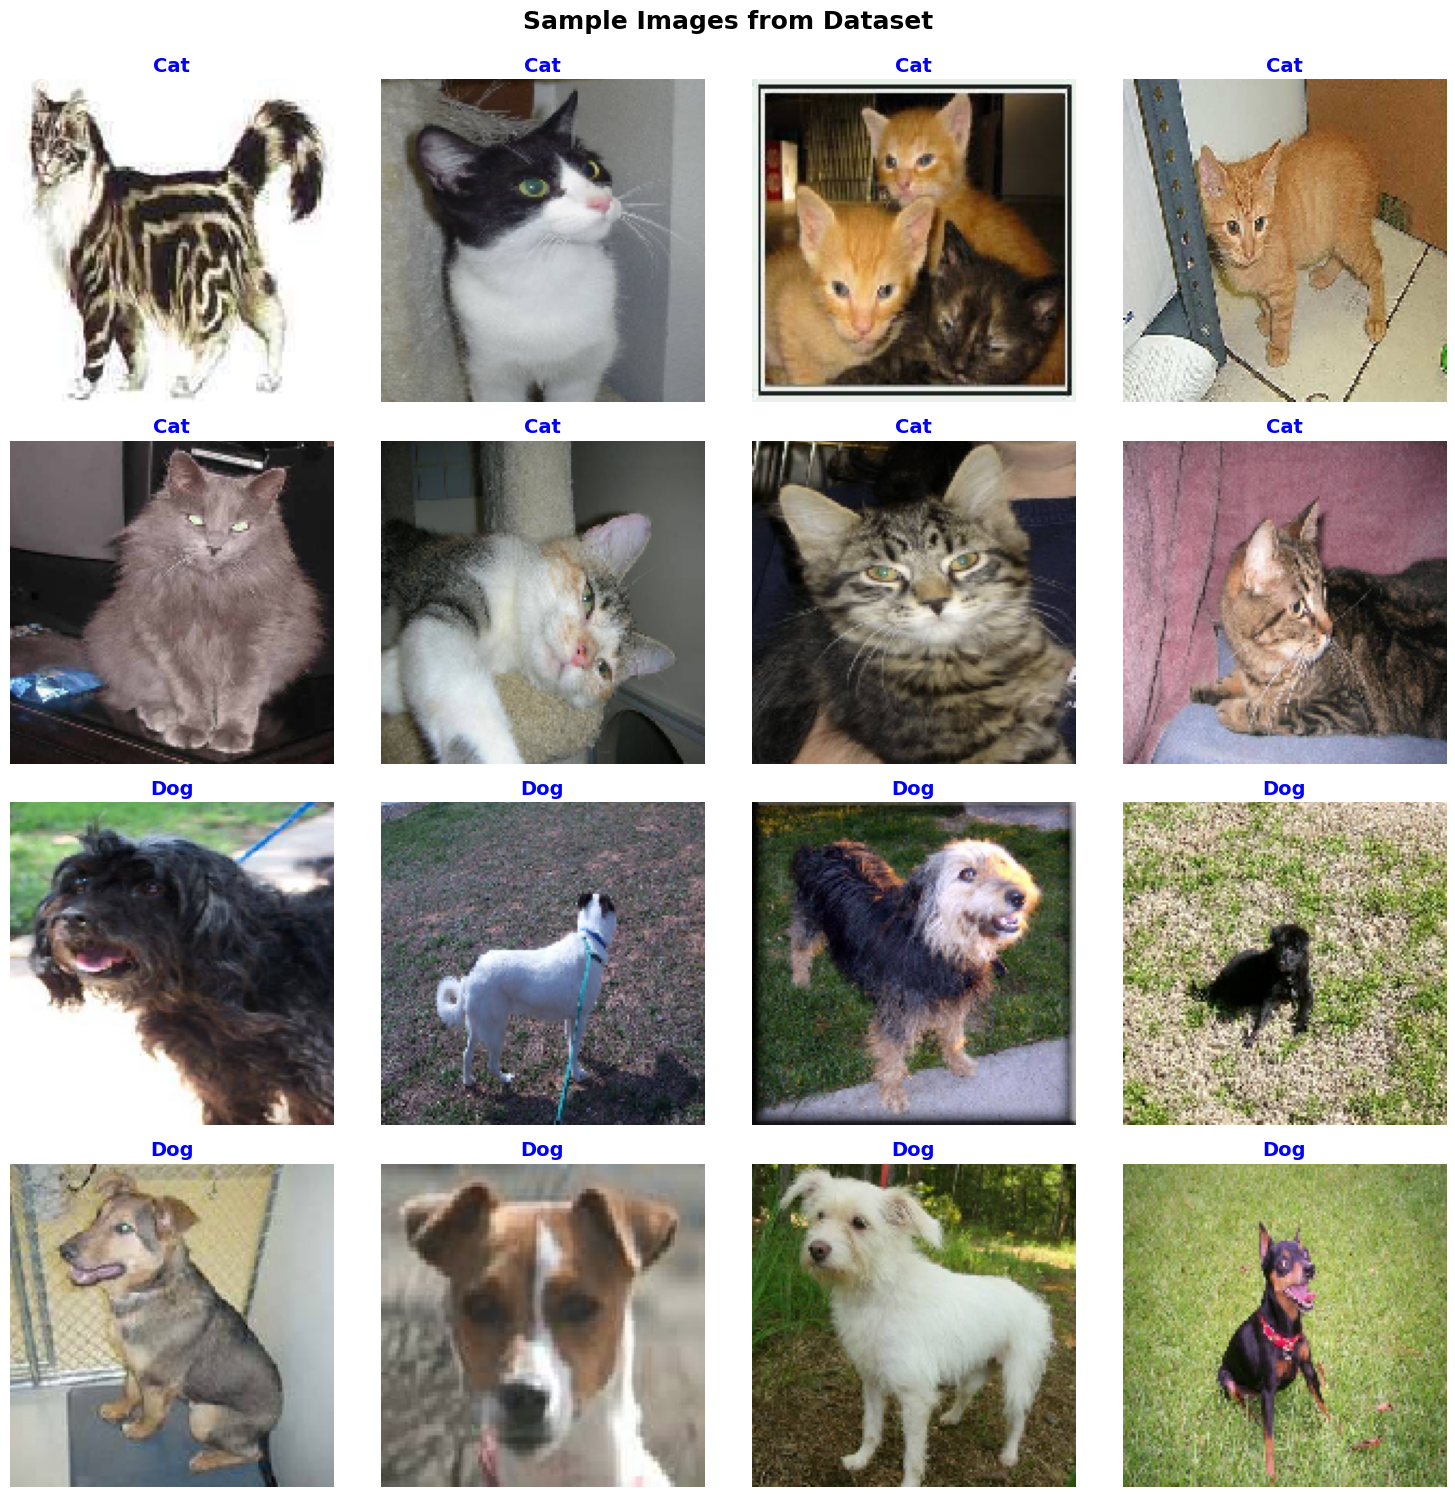

In [12]:
#Visualize Sample Images

print("="*50)
print("Visualize Sample Images")
print("="*50)


from tensorflow.keras.preprocessing import image

train_dir = '/content/data/train'

cat_dir = os.path.join(train_dir, 'cats')
dog_dir = os.path.join(train_dir, 'dogs')

sample_cat_files = os.listdir(cat_dir)[:8]
sample_dog_files = os.listdir(dog_dir)[:8]


fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for i in range(8):
    img_path = os.path.join(cat_dir, sample_cat_files[i])
    img = image.load_img(img_path, target_size= (150, 150))
    img_array = image.img_to_array(img)/255.0

    row = i//4
    col = i%4
    axes[row, col].imshow(img_array)
    axes[row, col].set_title("Cat", fontsize=14, fontweight= 'bold', color = 'blue')
    axes[row, col].axis('off')


for i in range(8):
    img_path = os.path.join(dog_dir, sample_dog_files[i])
    img = image.load_img(img_path, target_size= (150, 150))
    img_array = image.img_to_array(img)/255.0

    row = (i//4) +2
    col = i%4
    axes[row, col].imshow(img_array)
    axes[row, col].set_title("Dog", fontsize=14, fontweight= 'bold', color = 'blue')
    axes[row, col].axis('off')

plt.suptitle("Sample Images from Dataset",fontsize =18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [13]:


train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.15,
    horizontal_flip = True
)

val_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_generator = train_datagen.flow_from_directory(
    '/content/data/train',
    target_size = (160,160),
    batch_size = 32,
    class_mode = 'binary'
)


val_generator = val_datagen.flow_from_directory(
    '/content/data/val',
    target_size = (160,160),
    batch_size = 32,
    class_mode = 'binary'
)



Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [14]:
#Building The CNN

print("="*50)
print("Building the CNN")
print("="*50)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,  Input

model = Sequential([

    Input(shape=(160, 160, 3)),

    Conv2D(
        32,
        (3,3),
        activation = 'relu',
    ),
    MaxPooling2D(2,2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(512, activation='relu'),

    Dropout(0.5),

    Dense(1,activation= 'sigmoid')
])


model.summary()

Building the CNN


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,327,937 (81.36 MB)

 Trainable params: 21,327,937 (81.36 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 155s 237ms/step - accuracy: 0.5978 - loss: 0.6652 - val_accuracy: 0.6742 - val_loss: 0.6258
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 233ms/step - accuracy: 0.7137 - loss: 0.5611 - val_accuracy: 0.7676 - val_loss: 0.4857
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.7544 - loss: 0.5017 - val_accuracy: 0.7942 - val_loss: 0.4494
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 231ms/step - accuracy: 0.7845 - loss: 0.4559 - val_accuracy: 0.8038 - val_loss: 0.4428
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.8078 - loss: 0.4220 - val_accuracy: 0.8012 - val_loss: 0.4443
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.8229 - loss: 0.3934 - val_accuracy: 0.8318 - val_loss: 0.3856
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.8336 - loss: 0.3747 - val_accuracy: 0.8404 - val_loss: 0.3607
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 231ms/step - accuracy: 0.8424 -

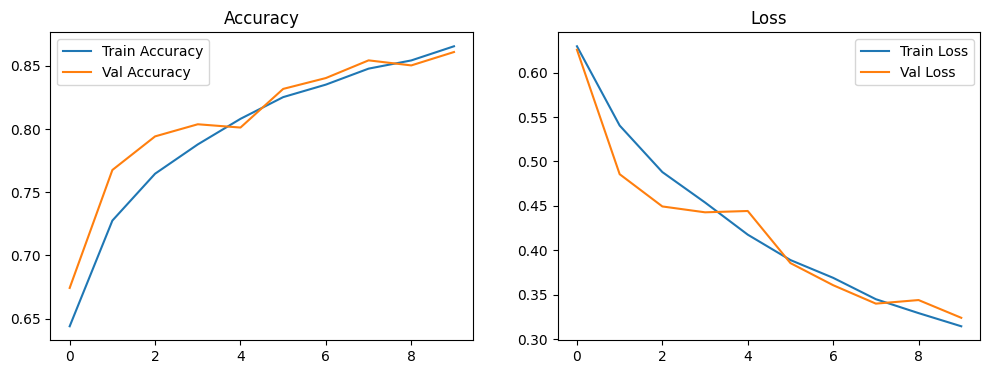

In [31]:
model.save('/content/my_model.keras')


acc = history.history['accuracy']
acc_number = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy']
val_acc_number= history.history['val_accuracy'][-1]
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Train Accuracy')
plt.plot(epochs_range, val_acc, label = 'Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [17]:
#Making predictions on val images

print("="*50)
print("Predictions")
print("="*50)

val_images, val_labels = next(val_generator)

predictions = model.predict(val_images, verbose=1)

Predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


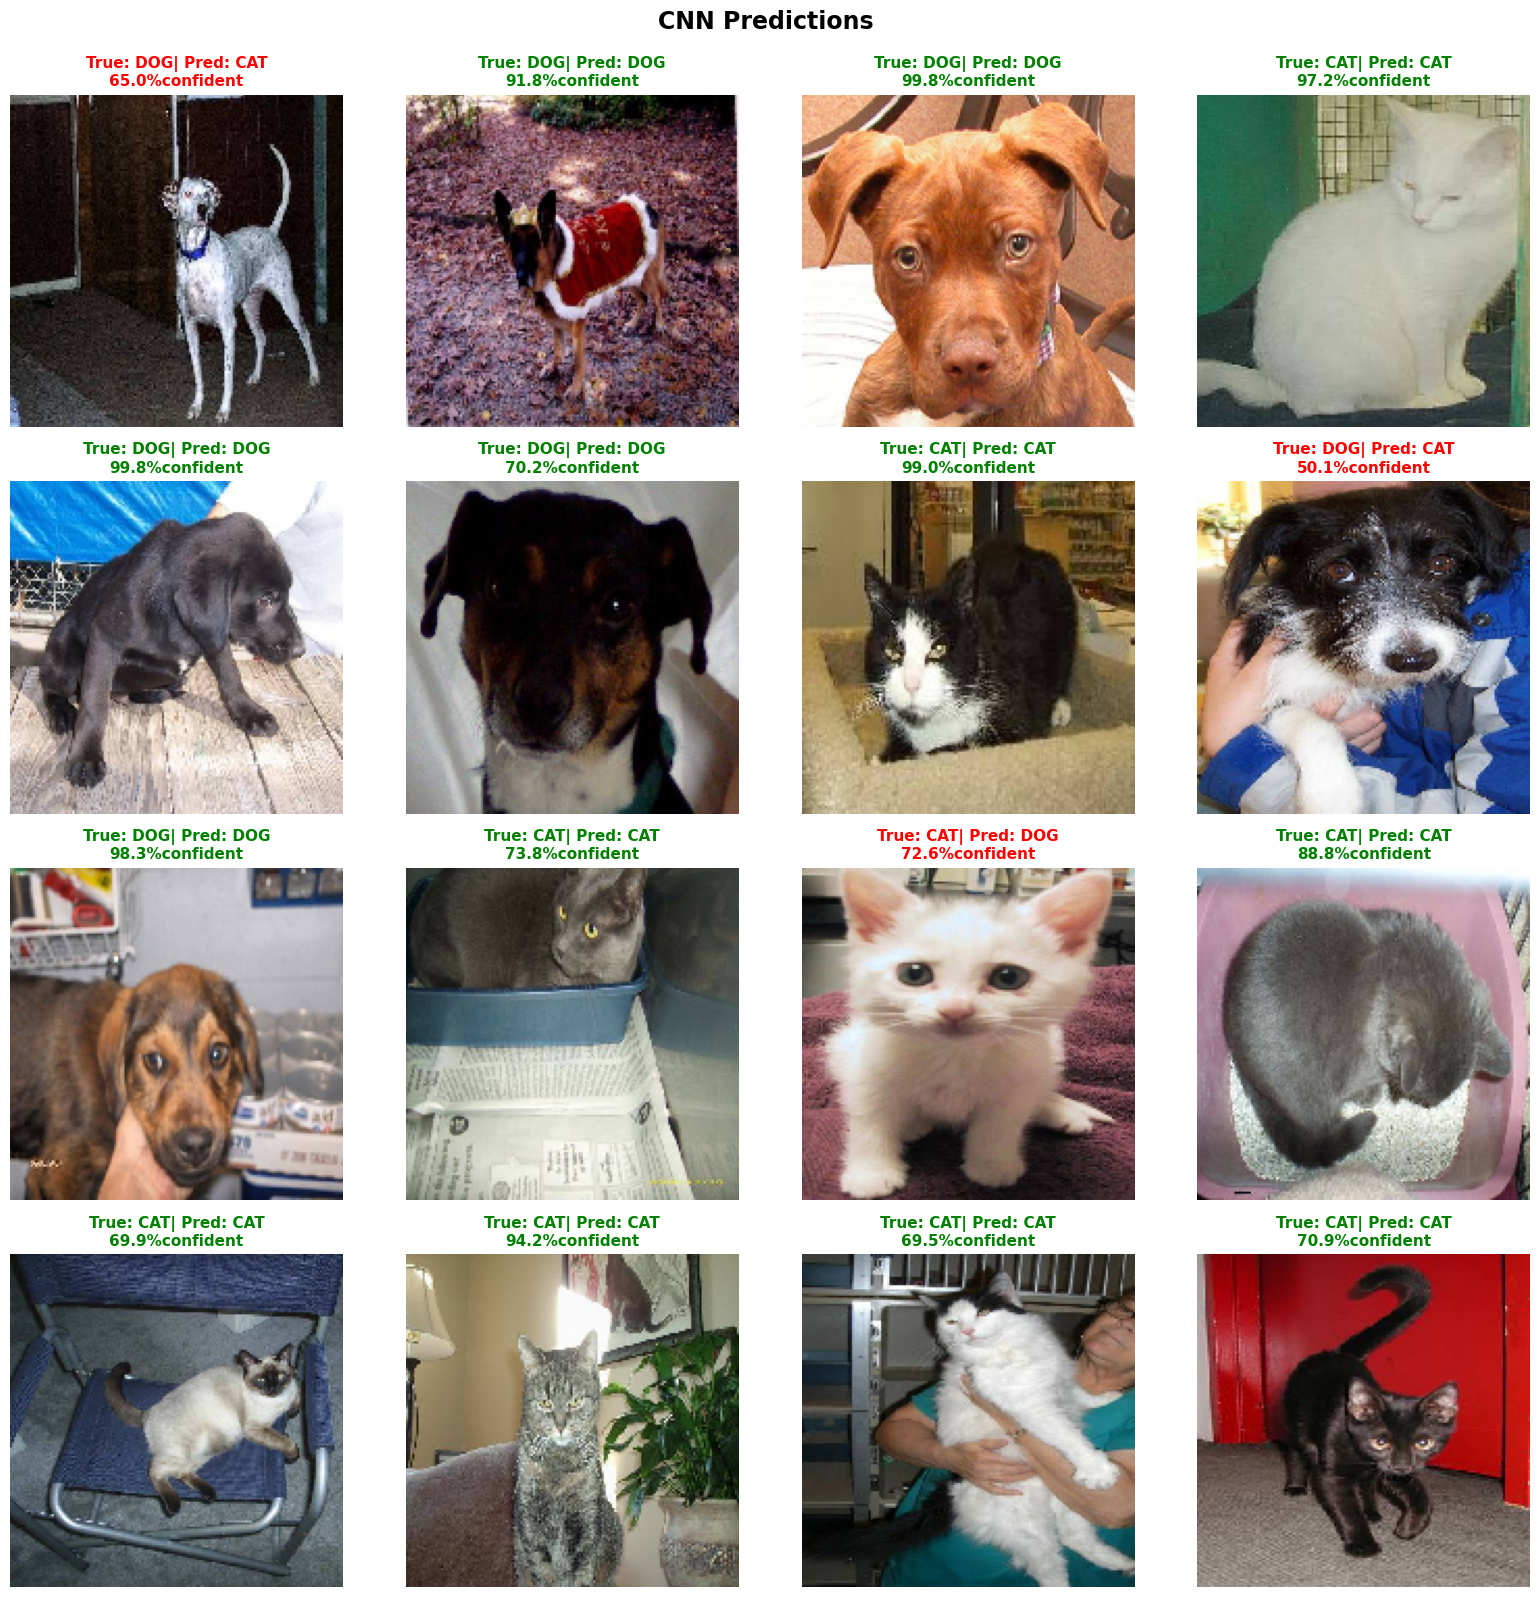

Got 27 out of 32 correct (84.38%)


In [18]:
#Visualize

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.ravel()

for i in range(16):
    axes[i].imshow(val_images[i])


    pred_prob = predictions[i][0]
    pred_class = 'DOG' if pred_prob >0.5 else "CAT"
    true_class = "DOG" if val_labels[i] == 1 else "CAT"

    confidence = pred_prob*100 if pred_prob >0.5 else (1-pred_prob)*100

    color = 'green' if pred_class == true_class else 'red'

    axes[i].set_title(
        f"True: {true_class}| Pred: {pred_class}\n{confidence:.1f}%confident",
        fontsize =11,
        color = color,
        fontweight = 'bold'
    )

    axes[i].axis('off')


plt.suptitle("CNN Predictions ", fontsize =17, fontweight = 'bold', y=0.995)
plt.tight_layout()
plt.show()

preds = (predictions > 0.5).astype(int).ravel()
correct = np.sum(preds == val_labels)

total = len(val_labels)
accuracy = correct / total

print(f"Got {correct} out of {total} correct ({accuracy*100:.2f}%)")

Confusion Matrix


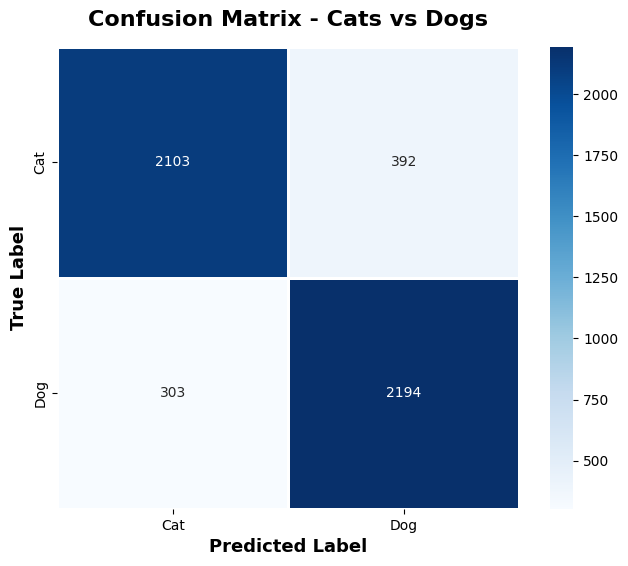


How to read
  Top-left: Cats correctly identified as cats (Good)
  Bottom-right: Dogs correctly identified as dogs (Good)
  Top-right: Cats wrongly predicted as dogs (Bad)
  Bottom-left: Dogs wrongly predicted as cats (Bad)


In [19]:
#Confusion Matrix

print("="*50)
print('Confusion Matrix')
print("="*50)

total_val = len(os.listdir("/content/data/val/cats"))+len(os.listdir("/content/data/val/dogs"))
batch_size = 32
val_generator.reset()
val_steps = total_val//batch_size

all_predictions = []
all_labels = []

for _ in range(val_steps):
    val_imgs, val_lbls = next(val_generator)
    preds =  model.predict(val_imgs, verbose =0)
    all_predictions.extend((preds>0.5).astype(int).flatten())
    all_labels.extend(val_lbls.astype(int))

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt ='d', cmap = 'Blues',
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'],
            cbar=True, square=True, linewidths=2)
plt.title('Confusion Matrix - Cats vs Dogs', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.show()

print("\nHow to read")
print("  Top-left: Cats correctly identified as cats (Good)")
print("  Bottom-right: Dogs correctly identified as dogs (Good)")
print("  Top-right: Cats wrongly predicted as dogs (Bad)")
print("  Bottom-left: Dogs wrongly predicted as cats (Bad)")

In [26]:
#classification report

print("="*50)
print("Detailed Classification Report")
print("="*50)

print(classification_report(all_labels, all_predictions, target_names=['Cat (0)', 'Dog (1)']))

Detailed Classification Report
              precision    recall  f1-score   support

     Cat (0)       0.87      0.84      0.86      2495
     Dog (1)       0.85      0.88      0.86      2497

    accuracy                           0.86      4992
   macro avg       0.86      0.86      0.86      4992
weighted avg       0.86      0.86      0.86      4992



Testing on random validation images...



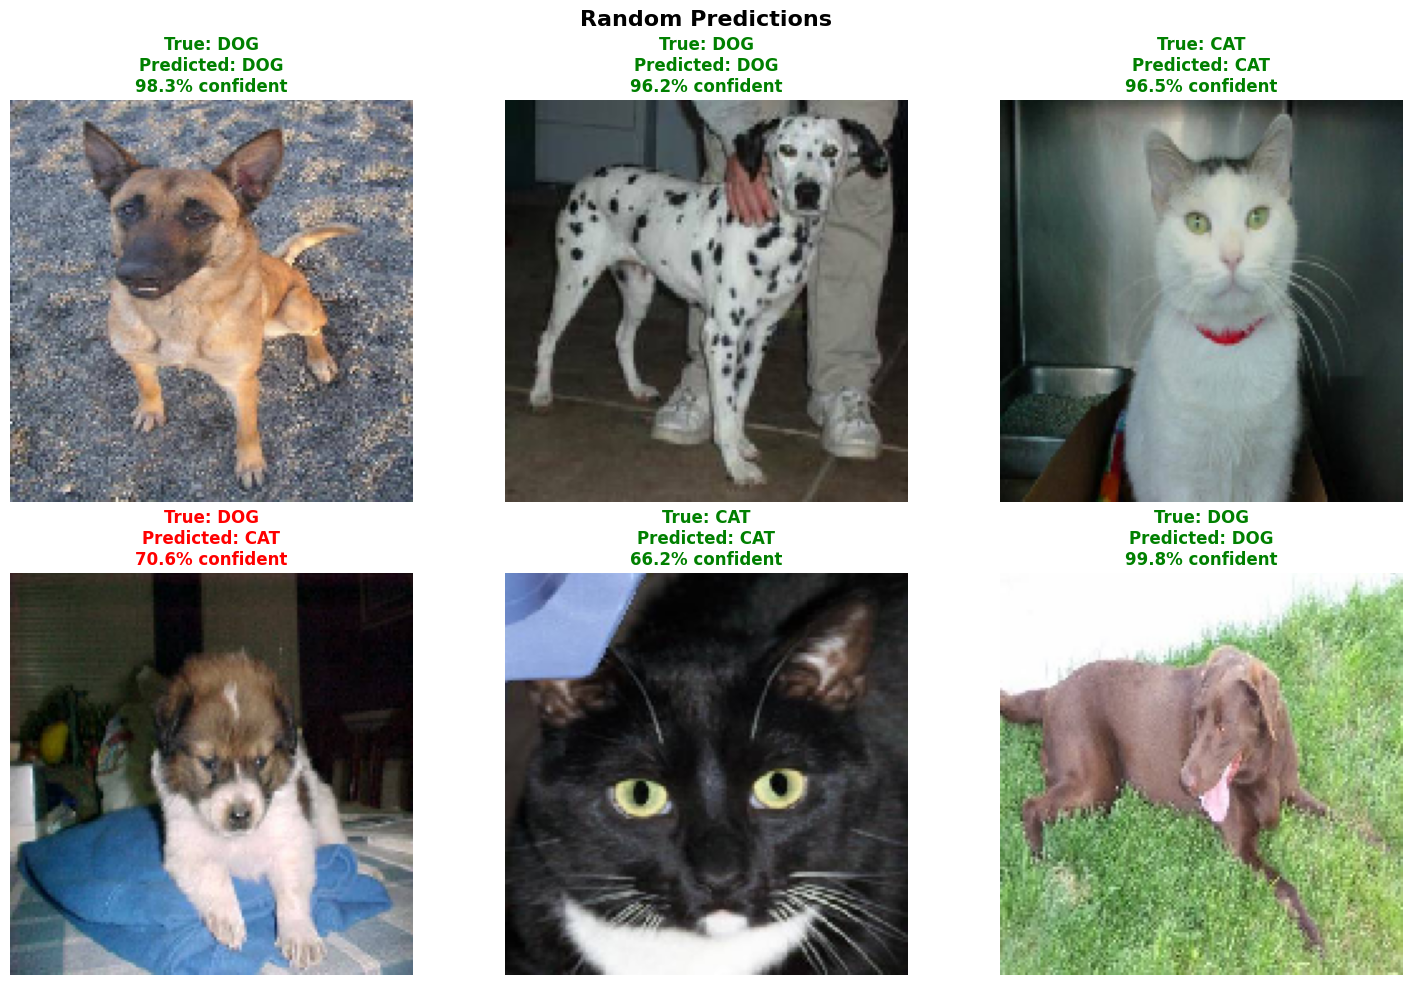

In [27]:
#RANDOM PREDICTIONS!
print("="*50)
print("Testing on random validation images...\n")
print("="*50)

val_generator.reset()

# Get random batch
random_batch_imgs, random_batch_labels = next(val_generator)

# Pick 6 random images
random_indices = np.random.choice(len(random_batch_imgs), 6, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img = random_batch_imgs[idx]
    true_label = random_batch_labels[idx]

    # Predict
    img_expanded = np.expand_dims(img, axis=0)
    prediction = model.predict(img_expanded, verbose=0)[0][0]

    pred_class = "DOG" if prediction > 0.5 else "CAT"
    true_class = "DOG" if true_label == 1 else "CAT"
    confidence = prediction * 100 if prediction > 0.5 else (1 - prediction) * 100

    # Display
    axes[i].imshow(img)
    color = 'green' if pred_class == true_class else 'red'

    axes[i].set_title(
        f"True: {true_class}\nPredicted: {pred_class}\n{confidence:.1f}% confident",
        fontsize=12,
        color=color,
        fontweight='bold'
    )
    axes[i].axis('off')

plt.suptitle("Random Predictions", fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [33]:
# PROJECT COMPLETE!

print("=" * 50)
print("Completed CNN")
print("=" * 50)

print("\nAccomplishment:")
print("Built a 4-layer Convolutional Neural Network")
total_train =  len(os.listdir("/content/data/train/dogs"))+ len(os.listdir("/content/data/train/cats"))
print(f"Trained on {total_train} cat and dog images")
print(f"Achieved {val_acc_number*100:.2f}% validation accuracy")
print("Learned data augmentation techniques")
print("Used GPU for fast training")
print(f"Model has {model.count_params():,} parameters")

print("\nCNN vs Regular NN:")
print("Regular NN (Day 3): Flattens images → loses spatial info")
print("CNN (Day 4): Preserves 2D structure → sees patterns!")
print("Result: WAY better for images!")

print("\nWhat makes CNNs special:")
print("Conv layers learn filters (edge detectors, pattern finders)")
print("Early layers: simple features (edges, colors)")
print("Later layers: complex features (eyes, ears, fur)")
print("It 'sees' images hierarchically, like humans!")

print("\n Results:")
print(f"Built a CNN! {acc_number*100:.1f}% accuracy on cats vs dogs!'")
print(f"Trained on {total_train} images with GPU!'")
print("_" * 50)

Completed CNN

Accomplishment:
Built a 4-layer Convolutional Neural Network
Trained on 20000 cat and dog images
Achieved 86.10% validation accuracy
Learned data augmentation techniques
Used GPU for fast training
Model has 21,327,937 parameters

CNN vs Regular NN:
Regular NN (Day 3): Flattens images → loses spatial info
CNN (Day 4): Preserves 2D structure → sees patterns!
Result: WAY better for images!

What makes CNNs special:
Conv layers learn filters (edge detectors, pattern finders)
Early layers: simple features (edges, colors)
Later layers: complex features (eyes, ears, fur)
It 'sees' images hierarchically, like humans!

 Results:
Built a CNN! 86.6% accuracy on cats vs dogs!'
Trained on 20000 images with GPU!'
__________________________________________________
